# Notebook 2: Modeling

This notebook ingests the transformed data from the Data Cleaning notebook and is reponsible for:

- Flattens the Transformed Data
- Tokenizes, truncates and pads the data using distilbert_base_uncased tokenizer.
- Aligns tokens with tags
- Transforms data for model training using DataCollator
- Performs a 80-20 test train split
- Trains and saves the model

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install seqeval
!pip install evaluate
!pip install transformers
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 617.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=8b31ebe9cb76d2a8b32402d3d453edf2550a8ac262be6d1db5e2b5e620305aa9
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from tqdm import tqdm,trange
import numpy as np
from sklearn.model_selection import train_test_split
import pydot
import matplotlib.pyplot as plt
import evaluate
import torch
from transformers import AutoModelForTokenClassification
from transformers import TrainingArguments
from transformers import DataCollatorForTokenClassification
from transformers import Trainer
from transformers import BertTokenizerFast
from transformers import AutoTokenizer

tqdm.pandas(desc="Progress")


# Import Clean Data

In [ ]:
df1=pd.read_parquet("/content/drive/Shareddrives/TM_project/transformed_data.parquet")

In [ ]:
df1

,Job Id,Tokenized Description,tags
1,1,"[[overview, reporting, director, data, integra...","[[O, O, O, B, I, O, O, O, O, O, O, O, O, O, O,..."
2,2,"[[research, associate, job, locationsus-ma-cam...","[[O, O, O, O, O, O, O, O, O], [O, O, O, O, O, ..."
3,3,"[[schneider, electric, creates, connected, tec...","[[O, O, O, O, O, O, O, O, O, O, O, O, O], [O, ..."
4,4,"[[working, location, :, massachusetts, ,, west...","[[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
5,5,"[[job, summary, :, product, management, profes...","[[O, O, O, B, I, O, O, O, O, O, B, O, O, O, O,..."
...,...,...,...
2279,2279,"[[auto, req, id, 55553br, job, code, i0857p, b...","[[O, O, O, O, O, O, O, B, I, O, O, O, O, O, O,..."
2280,2280,"[[auto, req, id, 55453br, job, code, i0758p, a...","[[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2281,2281,"[[auto, req, id, 54782br, job, code, f0957p, f...","[[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2282,2282,"[[auto, req, id, 54656br, job, code, i0958p, i...","[[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,..."


# Data Transformation

In [ ]:
flattened_sentences = []
tags = []
job_ids = []

# Iterating over each row in the DataFrame
for index, row in df1.iterrows():
    # Iterating over each sentence and tag in the lists
    for sentence, tag in zip(row['Tokenized Description'], row['tags']):
        job_ids.append(row['Job Id'])
        flattened_sentences.append(sentence)
        tags.append(tag)

# Creating a new DataFrame from the flattened lists
flattened_df = pd.DataFrame({
    "Job Id": job_ids,
    "Sentence": flattened_sentences,
    "Tags": tags
})

flattened_df


,Job Id,Sentence,Tags
0,1,"[overview, reporting, director, data, integrat...","[O, O, O, B, I, O, O, O, O, O, O, O, O, O, O, ..."
1,1,"[individual, expected, key, contributor, ideat...","[O, O, O, O, O, O, O, O, O, O, O, B, I, O, O, ..."
2,1,"[position, play, important, role, producing, d...","[O, O, O, O, O, B, O, O, O, O, O, O, O, O, O, ..."
3,1,"[opportunity, part, innovative, engineering, t...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,1,"[responsibilities, designs, ,, codes, ,, verif...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...
43330,2283,"[huit, currently, developing, hybrid, workplac...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
43331,2283,"[remote, scheduling, work, ,, agreed, supervis...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
43332,2283,"[individual, flexible, remote, work, options, ...","[O, O, O, O, O, O, O, O, O, O, O]"
43333,2283,"[harvard, require, covid, vaccination, harvard...","[O, O, O, O, O, O, O, O, O, O]"


In [ ]:
df_filtered = flattened_df[flattened_df['Tags'].apply(lambda x: 'B' in x)]
df_filtered = df_filtered[df_filtered['Sentence'].str.len() <= 512]
df_filtered

,Job Id,Sentence,Tags
0,1,"[overview, reporting, director, data, integrat...","[O, O, O, B, I, O, O, O, O, O, O, O, O, O, O, ..."
1,1,"[individual, expected, key, contributor, ideat...","[O, O, O, O, O, O, O, O, O, O, O, B, I, O, O, ..."
2,1,"[position, play, important, role, producing, d...","[O, O, O, O, O, B, O, O, O, O, O, O, O, O, O, ..."
4,1,"[responsibilities, designs, ,, codes, ,, verif...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7,1,"[designs, software, components, modules, using...","[O, O, O, O, O, O, O, O, O, O, O, B, O, O, O, ..."
...,...,...,...
43312,2283,"[huits, core, values, :, user-focusedcollabora...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
43313,2283,"[learn, :, https, :, //itacademy.harvard.edu/,...","[O, O, B, O, O, O, O, O, O, O, O, O, O, O, O, ..."
43324,2283,"[learn, :, https, :, //hr.harvard.edu/totalrew...","[O, O, B, O, O, O, O, O, O, O, O, O, O, O, O, ..."
43327,2283,"[typical, core, duties, work, high, level, wit...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


# BERT Tokenization

In [ ]:
model= "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokenizer.is_fast

True

In [ ]:
x=list(df_filtered["Sentence"].iloc[0])
x

['overview',
 'reporting',
 'director',
 'data',
 'integration',
 'services',
 ',',
 'ert',
 'looking',
 'full',
 'stack',
 'developer',
 'work',
 'key',
 'stakeholders',
 'applying',
 'technical',
 'proficiency',
 'across',
 'different',
 'stages',
 'software',
 'development',
 'life',
 'cycle',
 'including',
 'requirements',
 'gathering',
 ',',
 'application',
 'architecture',
 'design',
 '.']

In [ ]:
type(df_filtered['Sentence'])

pandas.core.series.Series

In [ ]:
def tokenize_and_truncate(sentence):
    # Tokenize with truncation and padding
    tokens = tokenizer(sentence,
                       max_length=512,
                       truncation=True,
                       padding='max_length',
                       return_tensors='pt',
                       is_split_into_words=True)

    return tokens
tokenized_sentences = df_filtered['Sentence'].progress_apply(lambda x: tokenize_and_truncate(list(x)))

# tokenized_sentences = df_filtered["Sentence"].apply(lambda x: tokenizer(list(x),is_split_into_words=True))

Progress: 100%|██████████| 18062/18062 [00:27<00:00, 659.69it/s] 


In [ ]:
bio_map={'O':0,'B':1,'I':2}

In [ ]:
df_filtered['numeric_tags'] = df_filtered['Tags'].apply(lambda tags: [bio_map[tag] for tag in tags if tag in bio_map])

In [ ]:
df_filtered=df_filtered.reset_index(drop=True)

In [ ]:
df_filtered

,Job Id,Sentence,Tags,numeric_tags
0,1,"[overview, reporting, director, data, integrat...","[O, O, O, B, I, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[individual, expected, key, contributor, ideat...","[O, O, O, O, O, O, O, O, O, O, O, B, I, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, ..."
2,1,"[position, play, important, role, producing, d...","[O, O, O, O, O, B, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1,"[responsibilities, designs, ,, codes, ,, verif...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,"[designs, software, components, modules, using...","[O, O, O, O, O, O, O, O, O, O, O, B, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...,...,...,...
18057,2283,"[huits, core, values, :, user-focusedcollabora...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
18058,2283,"[learn, :, https, :, //itacademy.harvard.edu/,...","[O, O, B, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
18059,2283,"[learn, :, https, :, //hr.harvard.edu/totalrew...","[O, O, B, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
18060,2283,"[typical, core, duties, work, high, level, wit...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df_filtered["Tags"][0]

array(['O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'O',
       'O', 'O', 'O', 'B', 'I', 'O', 'O'], dtype=object)

In [ ]:
len(tokenized_sentences)

18062

In [ ]:
filtered_sentences = tokenized_sentences[tokenized_sentences.apply(lambda x: len(x['input_ids']) <= 512)]
len(filtered_sentences)

18062

In [ ]:
len(df_filtered["numeric_tags"][0]),len(tokenized_sentences[0].tokens())

(33, 512)

# Tag alignment

Length of tags and tokenized words is different here which is why we need to align tags.

In [ ]:
def align_tokens_with_labels(labels, word_ids):
    new_labels = []
    current_word=None
    for word_id in word_ids:
      if word_id != current_word:
        current_word = word_id
        label = -100 if word_id is None else labels[word_id]
        new_labels.append(label)
      elif word_id is None:
        new_labels.append(-100)
      else:
        label = labels[word_id]
        if label%2==1:
          label = label + 1

        new_labels.append(label)
    return new_labels

In [ ]:
tokenized_sentences=tokenized_sentences.reset_index(drop=True)

In [ ]:
aligned_tag=align_tokens_with_labels(df_filtered["numeric_tags"][0],tokenized_sentences[0].word_ids())
len(aligned_tag),len(tokenized_sentences[0].tokens())

(512, 512)

In [ ]:
for i,j in zip(aligned_tag,tokenized_sentences[0].tokens()): # Checking if the function works with only the 0th index
  print(i,j)

-100 [CLS]
0 creates
0 communicate
0 ##s
0 multiple
1 design
0 views
0 identify
0 balance
0 concerns
0 stakeholders
0 software
1 design
0 allow
0 functional
0 non
0 -
0 functional
0 requirements
0 .
-100 [SEP]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD]
-100 [PAD

The above function works and now we can use it

In [ ]:
#Aligning tags for the whole dataframe
aligned_tags=[]
for i,tag in enumerate(df_filtered["numeric_tags"]):
  aligned_tags.append(align_tokens_with_labels(tag,tokenized_sentences[i].word_ids()))

In [ ]:
#Checking if all tags are aligned
index=0
ls=[]
for i,j in zip(aligned_tags,tokenized_sentences):
  if len(i)>512 or len(j)>512:
    ls.append(j)
    print (index)
  if len(aligned_tags)!=len(tokenized_sentences):
    print(index)
  index+=1
  for k,l in zip(i,j):
    if (l=='[SEP]' or l=='[CLS]' or l=='[PAD]') and (k!=-100):
      print(index)


# Transforming data for model training

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer,padding=False)

In [ ]:
type(tokenized_sentences[0])

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
tokenized_sentences

0        [input_ids, attention_mask]
1        [input_ids, attention_mask]
2        [input_ids, attention_mask]
3        [input_ids, attention_mask]
4        [input_ids, attention_mask]
                    ...             
18057    [input_ids, attention_mask]
18058    [input_ids, attention_mask]
18059    [input_ids, attention_mask]
18060    [input_ids, attention_mask]
18061    [input_ids, attention_mask]
Name: Sentence, Length: 18062, dtype: object

In [ ]:
for i, tags in enumerate(aligned_tags):
    tokenized_sentences[i]['labels'] = tags
    tokenized_sentences[i]['input_ids'] = tokenized_sentences[i]['input_ids'].squeeze()
    tokenized_sentences[i]['attention_mask'] = tokenized_sentences[i]['attention_mask'].squeeze()

In [ ]:
tokenized_sentences

0        [input_ids, attention_mask, labels]
1        [input_ids, attention_mask, labels]
2        [input_ids, attention_mask, labels]
3        [input_ids, attention_mask, labels]
4        [input_ids, attention_mask, labels]
                        ...                 
18057    [input_ids, attention_mask, labels]
18058    [input_ids, attention_mask, labels]
18059    [input_ids, attention_mask, labels]
18060    [input_ids, attention_mask, labels]
18061    [input_ids, attention_mask, labels]
Name: Sentence, Length: 18062, dtype: object

# Train test split

In [ ]:
train_data, test_data = train_test_split(tokenized_sentences, test_size=0.2, random_state=42)  # 80/20 split

train_data =train_data.reset_index(drop=True)
test_data =test_data.reset_index(drop=True)

In [ ]:
# len(train_data) + len(test_data)
type(tokenized_sentences)

pandas.core.series.Series

In [ ]:
# print(train_data[0]["input_ids"].ndim)
for i, data in enumerate(train_data):
  if len(data["input_ids"])>512:
    print(i," -- ",data["input_ids"])

In [ ]:
for i in range(len(df_filtered)):
  if len(df_filtered.iloc[i]["Sentence"]) > 512:
    print(len(df_filtered.iloc[i]["Sentence"]))

In [ ]:
batch=data_collator([i for i in train_data ])
batch

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[  101, 15644,  8117,  ...,     0,     0,     0],
        [  101,  6827,  5704,  ...,     0,     0,     0],
        [  101,  3325,  1024,  ...,     0,     0,     0],
        ...,
        [  101,  2804,  7570,  ...,     0,     0,     0],
        [  101,  2017,  3363,  ...,     0,     0,     0],
        [  101,  9090,  1011,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[-100,    0,    0,  ..., -100, -100, -100],
        [-100,    0,    0,  ..., -100, -100, -100],
        [-100,    0,    0,  ..., -100, -100, -100],
        ...,
        [-100,    0,    0,  ..., -100, -100, -100],
        [-100,    0,    0,  ..., -100, -100, -100],
        [-100,    0,    0,  ..., -100, -100, -100]])}

In [ ]:
batch['input_ids'].ndim,batch['labels'].ndim,batch['attention_mask'].ndim

(2, 2, 2)

In [ ]:
metric = evaluate.load('seqeval')

# Metic calculation

In [ ]:
label_names=['O','B','I']
def compute_metrics(eval_preds):
  logits, labels = eval_preds

  predictions = np.argmax(logits, axis=-1)

  true_labels = [[label_names[l] for l in label if l!=-100] for label in labels]

  true_predictions = [[label_names[p] for p,l in zip(prediction, label) if l!=-100]
                      for prediction, label in zip(predictions, labels)]

  all_metrics = metric.compute(predictions=true_predictions, references=true_labels)

  return {"precision": all_metrics['overall_precision'],
          "recall": all_metrics['overall_recall'],
          "f1": all_metrics['overall_f1'],
          "accuracy": all_metrics['overall_accuracy']}

In [ ]:
id2label = {i:label for i, label in enumerate(label_names)}
label2id = {label:i for i, label in enumerate(label_names)}


In [ ]:
model_f = AutoModelForTokenClassification.from_pretrained(
                                                    model,
                                                    id2label=id2label,
                                                    label2id=label2id)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_f.config.num_labels


3

# Hyperparameter Tuning and Model Training

In [ ]:
args = TrainingArguments("distilbert-finetuned-ner",
                         evaluation_strategy = "epoch",
                         save_strategy="epoch",
                         learning_rate = 2e-5,
                         num_train_epochs=3,
                         weight_decay=0.01)

In [ ]:
trainer = Trainer(model=model_f,
                  args=args,
                  train_dataset = train_data,
                  eval_dataset = test_data,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.081500,0.052436,0.878380,0.906783,0.892356,0.982703
2,0.036600,0.037228,0.933150,0.929218,0.931180,0.989165
3,0.022100,0.037300,0.929096,0.946809,0.937868,0.989842


TrainOutput(global_step=5421, training_loss=0.059176250613278907, metrics={'train_runtime': 2317.2624, 'train_samples_per_second': 18.706, 'train_steps_per_second': 2.339, 'total_flos': 5663522328652800.0, 'train_loss': 0.059176250613278907, 'epoch': 3.0})

In [ ]:
model_save_path = '/content/drive/Shareddrives/TM_project/saved_models/model_v1'
tokenizer_save_path = '/content/drive/Shareddrives/TM_project/saved_models/tokenizer_v1'

In [ ]:
trainer.save_model(model_save_path)

In [ ]:
tokenizer.save_pretrained(tokenizer_save_path)

('/content/drive/Shareddrives/TM_project/saved_models/tokenizer_v1/tokenizer_config.json',
 '/content/drive/Shareddrives/TM_project/saved_models/tokenizer_v1/special_tokens_map.json',
 '/content/drive/Shareddrives/TM_project/saved_models/tokenizer_v1/vocab.txt',
 '/content/drive/Shareddrives/TM_project/saved_models/tokenizer_v1/added_tokens.json',
 '/content/drive/Shareddrives/TM_project/saved_models/tokenizer_v1/tokenizer.json')

# Model Results Visulaizations

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the table provided by the user
data = {
    'Epoch': [1, 2, 3],
    'Accuracy': [0.982703, 0.989165, 0.989842],
    'Precision': [0.87838, 0.93315, 0.929096],
    'Recall': [0.906783, 0.929218, 0.946809],
    'F1': [0.892356, 0.93118, 0.937868]
}

# Create DataFrame from the data
results_df = pd.DataFrame(data)

<ipython-input-7-266b13debbaa>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


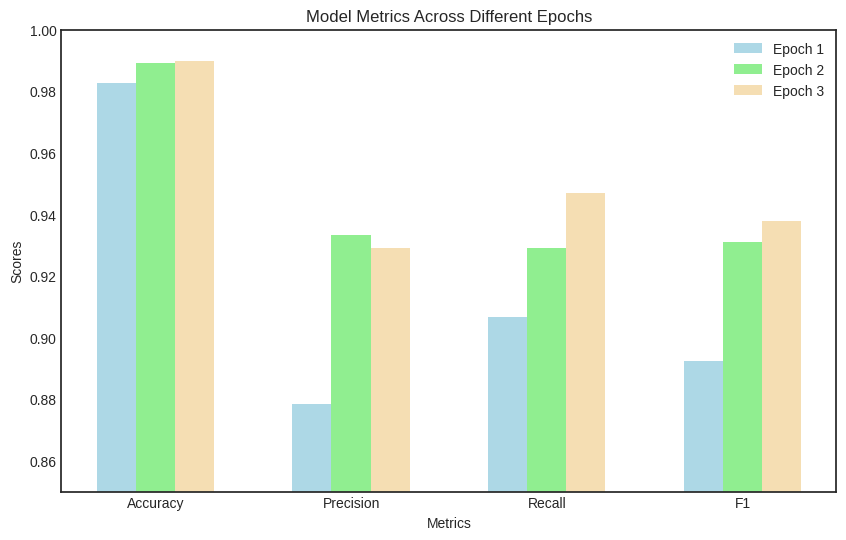

In [ ]:
# Set up the matplotlib figure with a light theme
plt.style.use('seaborn-white')

df_transposed = results_df.set_index('Epoch').T
metrics = df_transposed.index.tolist()
x = range(len(metrics))  # the label locations
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# Draw the bars with a lighter color palette
colors = ['lightblue', 'lightgreen', 'wheat']
rects1 = ax.bar(x, results_df.iloc[0][metrics].values, width, label='Epoch 1', color=colors[0])
rects2 = ax.bar([p + width for p in x], results_df.iloc[1][metrics].values, width, label='Epoch 2', color=colors[1])
rects3 = ax.bar([p + width*2 for p in x], results_df.iloc[2][metrics].values, width, label='Epoch 3', color=colors[2])

# Add some text for labels, title and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Metrics Across Different Epochs')
ax.set_xticks([p + width for p in x])
ax.set_xticklabels(metrics)
ax.set_ylim(0.85, 1)  # Set y-axis scaling from 0.85 to 1
ax.legend()  # Move the legend to lower right corner

# Show the plot
plt.show()


<ipython-input-8-d94a05a25804>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


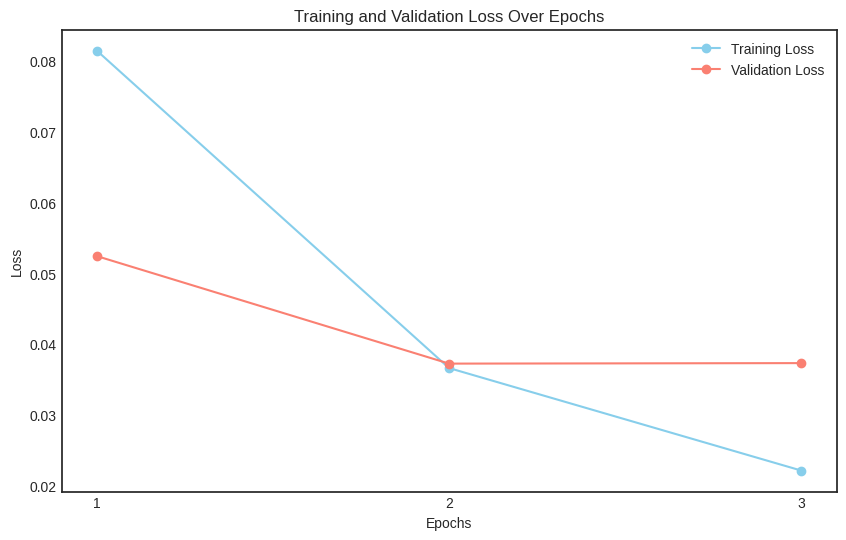

In [ ]:
# Set up the matplotlib figure with a light theme
plt.style.use('seaborn-white')

# Extract loss data for the line graph
loss_data = {
    'Epoch': [1, 2, 3],
    'Training Loss': [0.0815, 0.0366, 0.0221],
    'Validation Loss': [0.052436, 0.037228, 0.0373]
}
loss_df = pd.DataFrame(loss_data)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the training and validation loss as lines
ax.plot(loss_df['Epoch'], loss_df['Training Loss'], label='Training Loss', marker='o', color='skyblue')
ax.plot(loss_df['Epoch'], loss_df['Validation Loss'], label='Validation Loss', marker='o', color='salmon')

# Add some text for labels, title and custom x-axis tick labels
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss Over Epochs')
ax.set_xticks(loss_df['Epoch'])
ax.legend(loc='upper right')  # Move the legend to lower right corner

# Show the plot
plt.show()
